In [1]:
import dataloaders.audio_dataset as dataset
import models.inversion_v2 as inversion_model
from abstract_model import AbstractModel

import os
import shutil

import torch
import torchaudio
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
import torchaudio.functional as F

from sklearn.metrics import confusion_matrix

from pytorch_lightning.core.saving import load_hparams_from_yaml

from tensorboard.backend.event_processing import event_accumulator
import numpy as np

from torch.utils.data import DataLoader

import librosa
import librosa.display

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
n_dft = 2048
n_mels = 128
n_hop = 242
asr = 48000

In [3]:
def _load_run(path):
    event_acc = event_accumulator.EventAccumulator(path)
    event_acc.Reload()
    data = {}

    for tag in sorted(event_acc.Tags()["scalars"]):
        x, y = [], []

        for scalar_event in event_acc.Scalars(tag):
            x.append(scalar_event.step)
            y.append(scalar_event.value)

        data[tag] = (np.asarray(x), np.asarray(y))
    return data

In [27]:
# TEST - SPECIFIC VERSION - MSE loss and amplitude prediction

algo = "inversion_v2"
data_path = "/scratch/prs392/incubator/data/LibriSpeech/"
checkpoint_path = f"/scratch/prs392/incubator/checkpoints/openl3_librispeech/{algo}/"
# experiment_name = "train_1000_audio_with_specific_hparams_with_emb_means_and_stds"
experiment_name = "train_1000_audio_with_specific_hparams"

AudioDatasetWithAmp = dataset.AudioDataset
InversionV2 = inversion_model.InversionV2

data_paths = {}
data_paths['train'] = os.path.join(data_path, 'train-clean-360')
data_paths['val'] = os.path.join(data_path, 'dev-clean')
data_paths['test'] = os.path.join(data_path, 'test-clean')

d = os.path.join(checkpoint_path, experiment_name)
versions = [o for o in os.listdir(d) if os.path.isdir(os.path.join(d,o))]

versions = sorted(versions)

for version in versions:
    if version == 'version_1':
        hparam_path = os.path.join(checkpoint_path, experiment_name, version, 'hparams.yaml')
#         hparams_new = load_hparams_from_yaml(hparam_path)

with open(os.path.join(data_paths['train'], 'embeddings_6144', 'random_500_audios_embeddings.npy'), 'rb') as f:
    list_of_embedding_frames = np.load(f)
    
with open(os.path.join(data_paths['train'], 'spectrograms', 'random_500_audios_specs_mean.npy'), 'rb') as f:
    spec_means = np.load(f)
    
with open(os.path.join(data_paths['train'], 'spectrograms', 'random_500_audios_specs_std.npy'), 'rb') as f:
    spec_stds = np.load(f)

hparams_new = {
    'batch_size': 64,
    'lr': 0.0004136762567284789,
    'lr_type': 'adam',
    'scheduler_epoch': 1,
    'scheduler_step_size': 0.9465236907824874,
    'emb_means': list_of_embedding_frames.mean(axis=0),
    'emb_stds':list_of_embedding_frames.std(axis=0),
    'spec_means': spec_means,
    'spec_stds': spec_stds
}

version = 'version_0'

checkpoint_path = os.path.join(checkpoint_path, experiment_name, version, 'checkpoints')
epoch_file = [o for o in os.listdir(checkpoint_path) if os.path.isfile(os.path.join(checkpoint_path,o))][1]

PATH = os.path.join(checkpoint_path, f'{epoch_file}') 

print(hparams_new)
print(epoch_file)

model = AbstractModel.load_from_checkpoint(PATH, hparams=hparams_new, 
                                            data_paths = data_paths, 
                                            dataset_model = AudioDatasetWithAmp,
                                            model = InversionV2(), 
                                            criterion = nn.MSELoss())

model = model.eval()

train_dataset = AudioDatasetWithAmp(
    root_dir=data_paths['test'], 
    num_audios = 1000, 
    return_amp = True, 
#     emb_means=list_of_embedding_frames.mean(axis=0), 
#     emb_stds=list_of_embedding_frames.std(axis=0)
)
# train_dataset = AudioDatasetWithAmp(root_dir=data_paths['test'], num_audios = 1000, return_amp = True)
# train_loader = DataLoader(train_dataset, batch_size=hparams_new['batch_size'], shuffle=False, num_workers=4, pin_memory=True)




{'batch_size': 64, 'lr': 0.0004136762567284789, 'lr_type': 'adam', 'scheduler_epoch': 1, 'scheduler_step_size': 0.9465236907824874, 'emb_means': array([ 1.1972656 , -0.04162345,  1.0635653 , ...,  0.58443135,
        1.2051384 ,  2.5238538 ], dtype=float32), 'emb_stds': array([0.6269768 , 0.23699315, 0.4800284 , ..., 0.07191464, 0.05293078,
       0.2366121 ], dtype=float32), 'spec_means': array([[[0.17823456, 0.1835684 , 0.17356669, ..., 0.16794217,
         0.17702117, 0.17122662],
        [0.18279658, 0.18558587, 0.1739925 , ..., 0.1683288 ,
         0.17881936, 0.17550689],
        [0.19130822, 0.19350225, 0.17905354, ..., 0.17280251,
         0.18596955, 0.1830777 ],
        ...,
        [0.01497173, 0.01359738, 0.01037071, ..., 0.00978747,
         0.01281919, 0.01410495],
        [0.01493131, 0.01356068, 0.01034271, ..., 0.00976109,
         0.01278464, 0.01406693],
        [0.01490542, 0.01353716, 0.01032478, ..., 0.00974421,
         0.01276252, 0.0140426 ]]]), 'spec_stds': ar

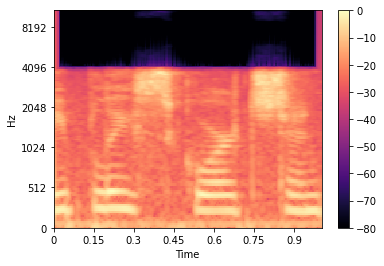

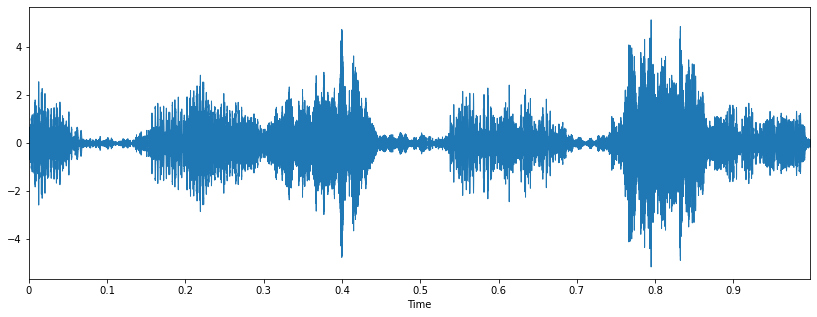

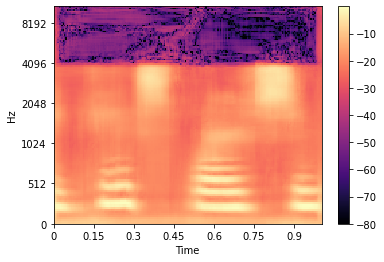

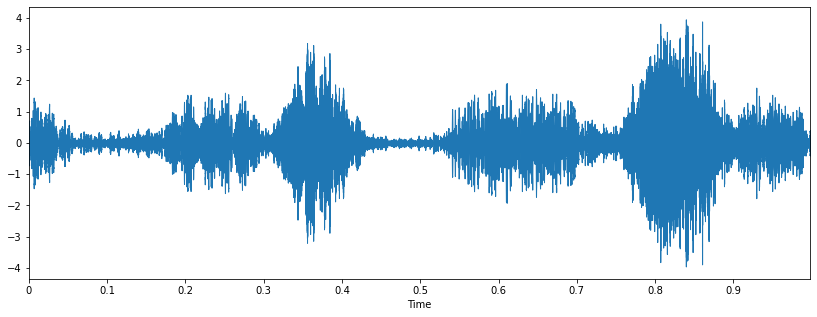

In [37]:
for i in range(len(train_dataset)):
    emb, spec, j = train_dataset[i]

    if i == 50:
        pred = model(emb)
        break
        
plt.subplots()
librosa.display.specshow(librosa.amplitude_to_db(np.abs(spec[:,:,:].detach().numpy())[0,:,:], ref=np.max), 
                         y_axis='mel', 
                         x_axis='time',
                         sr=asr,
                         hop_length=n_hop)
plt.colorbar()


import torchaudio.functional as F

n_dft = 2048
n_mels = 128
n_hop = 242
asr = 48000

# spec_tensor_amp = F.DB_to_amplitude(x = spec[0,:,:].detach(), ref = 1, power = 1)
spec_tensor_amp = np.abs(spec[:,:,:].detach().numpy())[0,:,:]


y = librosa.feature.inverse.mel_to_audio(spec_tensor_amp, sr=asr, n_fft=n_dft, hop_length=n_hop, center=True, n_iter=32,  power=0.5)
# y *= 32767 / max (0.01, np.max(np.abs(y)))
plt.figure(figsize=(14, 5))
librosa.display.waveplot(y, sr=48000)
import IPython.display as ipd

import IPython

IPython.display.display(ipd.Audio(y, rate=48000))

plt.subplots()
pred_spec_tensor_amp = np.abs(pred[0].detach().numpy())[0,:,:]

librosa.display.specshow(
    librosa.amplitude_to_db(pred_spec_tensor_amp, ref=np.max), 
    y_axis='mel', 
    x_axis='time',
    sr=asr,
    hop_length=n_hop
)
plt.colorbar()


import torchaudio.functional as F

n_dft = 2048
n_mels = 128
n_hop = 242
asr = 48000

# spec_tensor_amp = F.DB_to_amplitude(x = spec[0,:,:].detach(), ref = 1, power = 1)
spec_tensor_amp = np.abs(pred[0].detach().numpy())[0,:,:]


y = librosa.feature.inverse.mel_to_audio(spec_tensor_amp, sr=asr, n_fft=n_dft, hop_length=n_hop, center=True, n_iter=32,  power=0.5)
# y *= 32767 / max (0.01, np.max(np.abs(y)))
plt.figure(figsize=(14, 5))
librosa.display.waveplot(y, sr=48000)
import IPython.display as ipd

IPython.display.display(ipd.Audio(y, rate=48000))


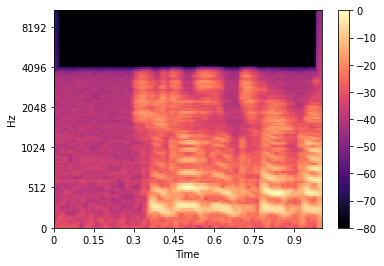

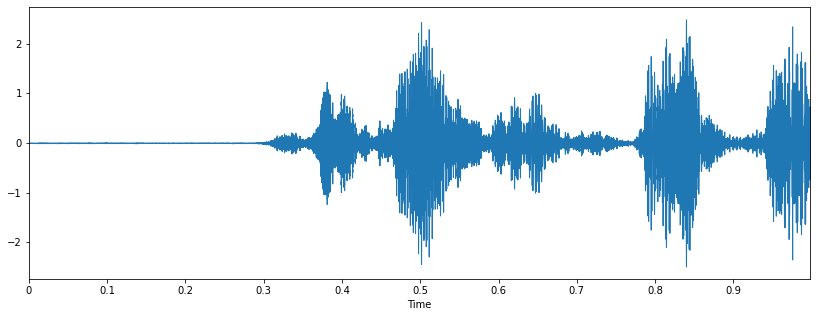

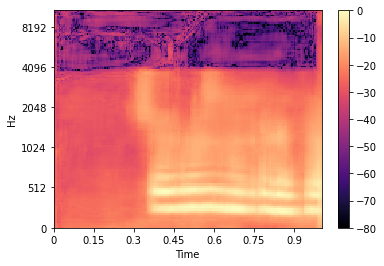

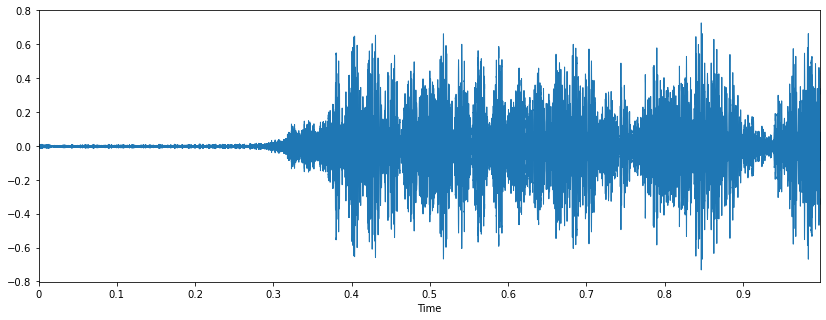

In [38]:
for i in range(len(train_dataset)):
    emb, spec, j = train_dataset[i]

    if i == 0:
        pred = model(emb)
        break
        
plt.subplots()
librosa.display.specshow(librosa.amplitude_to_db(np.abs(spec[:,:,:].detach().numpy())[0,:,:], ref=np.max), 
                         y_axis='mel', 
                         x_axis='time',
                         sr=asr,
                         hop_length=n_hop)
plt.colorbar()


import torchaudio.functional as F

n_dft = 2048
n_mels = 128
n_hop = 242
asr = 48000

# spec_tensor_amp = F.DB_to_amplitude(x = spec[0,:,:].detach(), ref = 1, power = 1)
spec_tensor_amp = np.abs(spec[:,:,:].detach().numpy())[0,:,:]


y = librosa.feature.inverse.mel_to_audio(spec_tensor_amp, sr=asr, n_fft=n_dft, hop_length=n_hop, center=True, n_iter=32,  power=0.5)
# y *= 32767 / max (0.01, np.max(np.abs(y)))
plt.figure(figsize=(14, 5))
librosa.display.waveplot(y, sr=48000)
import IPython.display as ipd

import IPython

IPython.display.display(ipd.Audio(y, rate=48000))

plt.subplots()
pred_spec_tensor_amp = np.abs(pred[0].detach().numpy())[0,:,:]

librosa.display.specshow(
    librosa.amplitude_to_db(pred_spec_tensor_amp, ref=np.max), 
    y_axis='mel', 
    x_axis='time',
    sr=asr,
    hop_length=n_hop
)
plt.colorbar()


import torchaudio.functional as F

n_dft = 2048
n_mels = 128
n_hop = 242
asr = 48000

# spec_tensor_amp = F.DB_to_amplitude(x = spec[0,:,:].detach(), ref = 1, power = 1)
spec_tensor_amp = np.abs(pred[0].detach().numpy())[0,:,:]


y = librosa.feature.inverse.mel_to_audio(spec_tensor_amp, sr=asr, n_fft=n_dft, hop_length=n_hop, center=True, n_iter=32,  power=0.5)
# y *= 32767 / max (0.01, np.max(np.abs(y)))
plt.figure(figsize=(14, 5))
librosa.display.waveplot(y, sr=48000)
import IPython.display as ipd

IPython.display.display(ipd.Audio(y, rate=48000))
